In [51]:
import dgl
import numpy as np
import networkx as nx
from dgl.nn.pytorch import GraphConv

import torch
import torch.nn as nn
import torch.nn.functional as F

In [52]:
def build_karate_club_graph():
    # All 78 edges are stored in two numpy arrays. One for source endpoints
    # while the other for destination endpoints.
    src = np.array([1, 2, 2, 3, 3, 3, 4, 5, 6, 6, 6, 7, 7, 7, 7, 8, 8, 9, 10, 10,
        10, 11, 12, 12, 13, 13, 13, 13, 16, 16, 17, 17, 19, 19, 21, 21,
        25, 25, 27, 27, 27, 28, 29, 29, 30, 30, 31, 31, 31, 31, 32, 32,
        32, 32, 32, 32, 32, 32, 32, 32, 32, 33, 33, 33, 33, 33, 33, 33,
        33, 33, 33, 33, 33, 33, 33, 33, 33, 33])
    dst = np.array([0, 0, 1, 0, 1, 2, 0, 0, 0, 4, 5, 0, 1, 2, 3, 0, 2, 2, 0, 4,
        5, 0, 0, 3, 0, 1, 2, 3, 5, 6, 0, 1, 0, 1, 0, 1, 23, 24, 2, 23,
        24, 2, 23, 26, 1, 8, 0, 24, 25, 28, 2, 8, 14, 15, 18, 20, 22, 23,
        29, 30, 31, 8, 9, 13, 14, 15, 18, 19, 20, 22, 23, 26, 27, 28, 29, 30,
        31, 32])
    # Edges are directional in DGL; Make them bi-directional.
    u = np.concatenate([src, dst])
    v = np.concatenate([dst, src])
    # Construct a DGLGraph
    return dgl.DGLGraph((u, v))

In [53]:
G = build_karate_club_graph()
print('We have %d nodes.' % G.number_of_nodes())
print('We have %d edges.' % G.number_of_edges())

We have 34 nodes.
We have 156 edges.


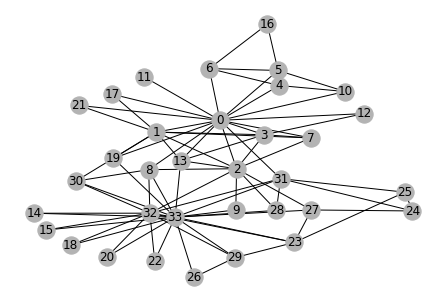

In [54]:
# Since the actual graph is undirected, we convert it for visualization
# purpose.
nx_G = G.to_networkx().to_undirected()
# Kamada-Kawaii layout usually looks pretty for arbitrary graphs
pos = nx.kamada_kawai_layout(nx_G)
nx.draw(nx_G, pos, with_labels=True, node_color=[[.7, .7, .7]])

In [55]:
embed = nn.Embedding(34, 5)  # 34 nodes with embedding dim equal to 5
G.ndata['feat'] = embed.weight

In [56]:
# print out node 2's input feature
print(G.ndata['feat'][2])

# print out node 10 and 11's input features
print(G.ndata['feat'][[10, 11]])

tensor([-2.4482, -0.2325,  0.8502, -1.8217,  2.3851], grad_fn=<SelectBackward>)
tensor([[-0.0527, -1.7083,  0.0997, -0.5313, -1.0390],
        [-0.5880,  0.3673, -0.3790,  0.4400,  0.3349]],
       grad_fn=<IndexBackward>)


In [57]:
class GCN(nn.Module):
    def __init__(self, in_feats, hidden_size, num_classes):
        super(GCN, self).__init__()
        self.conv1 = GraphConv(in_feats, hidden_size)
        self.conv2 = GraphConv(hidden_size, num_classes)

    def forward(self, g, inputs):
        h = self.conv1(g, inputs)
        h = torch.relu(h)
        h = self.conv2(g, h)
        return h

# The first layer transforms input features of size of 5 to a hidden size of 5.
# The second layer transforms the hidden layer and produces output features of
# size 2, corresponding to the two groups of the karate club.
net = GCN(5, 5, 2)

In [58]:
net

GCN(
  (conv1): GraphConv(in=5, out=5, normalization=both, activation=None)
  (conv2): GraphConv(in=5, out=2, normalization=both, activation=None)
)

In [59]:
inputs = embed.weight
labeled_nodes = torch.tensor([0, 33])  # only the instructor and the president nodes are labeled
labels = torch.tensor([0, 1])  # their labels are different

In [60]:
import itertools

optimizer = torch.optim.Adam(itertools.chain(net.parameters(), embed.parameters()), lr=0.01)
all_logits = []
for epoch in range(50):
    logits = net(G, inputs)
    # we save the logits for visualization later
    all_logits.append(logits.detach())
    logp = F.log_softmax(logits, 1)
    # we only compute loss for labeled nodes
    loss = F.nll_loss(logp[labeled_nodes], labels)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    print('Epoch %d | Loss: %.4f' % (epoch, loss.item()))

Epoch 0 | Loss: 0.7071
Epoch 1 | Loss: 0.6798
Epoch 2 | Loss: 0.6553
Epoch 3 | Loss: 0.6302
Epoch 4 | Loss: 0.6078
Epoch 5 | Loss: 0.5861
Epoch 6 | Loss: 0.5652
Epoch 7 | Loss: 0.5450
Epoch 8 | Loss: 0.5256
Epoch 9 | Loss: 0.5084
Epoch 10 | Loss: 0.4933
Epoch 11 | Loss: 0.4788
Epoch 12 | Loss: 0.4647
Epoch 13 | Loss: 0.4504
Epoch 14 | Loss: 0.4372
Epoch 15 | Loss: 0.4242
Epoch 16 | Loss: 0.4118
Epoch 17 | Loss: 0.4001
Epoch 18 | Loss: 0.3881
Epoch 19 | Loss: 0.3768
Epoch 20 | Loss: 0.3653
Epoch 21 | Loss: 0.3541
Epoch 22 | Loss: 0.3429
Epoch 23 | Loss: 0.3315
Epoch 24 | Loss: 0.3199
Epoch 25 | Loss: 0.3080
Epoch 26 | Loss: 0.2955
Epoch 27 | Loss: 0.2829
Epoch 28 | Loss: 0.2703
Epoch 29 | Loss: 0.2576
Epoch 30 | Loss: 0.2447
Epoch 31 | Loss: 0.2319
Epoch 32 | Loss: 0.2190
Epoch 33 | Loss: 0.2063
Epoch 34 | Loss: 0.1936
Epoch 35 | Loss: 0.1812
Epoch 36 | Loss: 0.1691
Epoch 37 | Loss: 0.1573
Epoch 38 | Loss: 0.1460
Epoch 39 | Loss: 0.1349
Epoch 40 | Loss: 0.1243
Epoch 41 | Loss: 0.1145
Ep

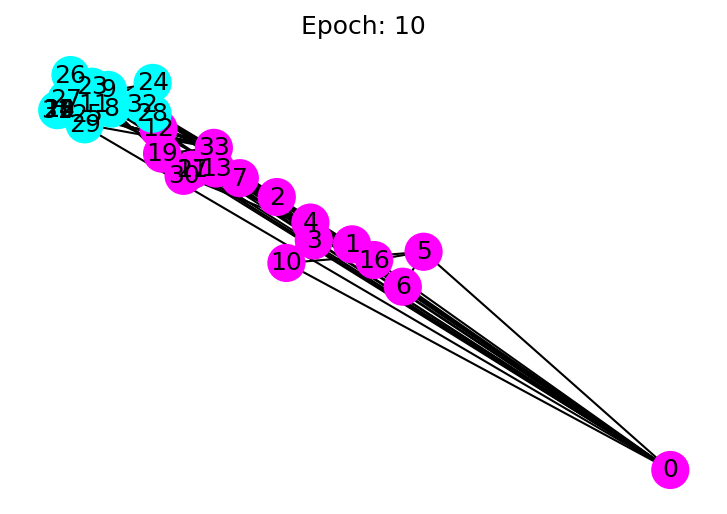

In [61]:
import matplotlib.animation as animation
import matplotlib.pyplot as plt

def draw(i):
    cls1color = '#00FFFF'
    cls2color = '#FF00FF'
    pos = {}
    colors = []
    for v in range(34):
        pos[v] = all_logits[i][v].numpy()
        cls = pos[v].argmax()
        colors.append(cls1color if cls else cls2color)
    ax.cla()
    ax.axis('off')
    ax.set_title('Epoch: %d' % i)
    nx.draw_networkx(nx_G.to_undirected(), pos, node_color=colors,
            with_labels=True, node_size=300, ax=ax)

fig = plt.figure(dpi=150)
fig.clf()
ax = fig.subplots()
draw(10)  # draw the prediction of the first epoch
#plt.close()

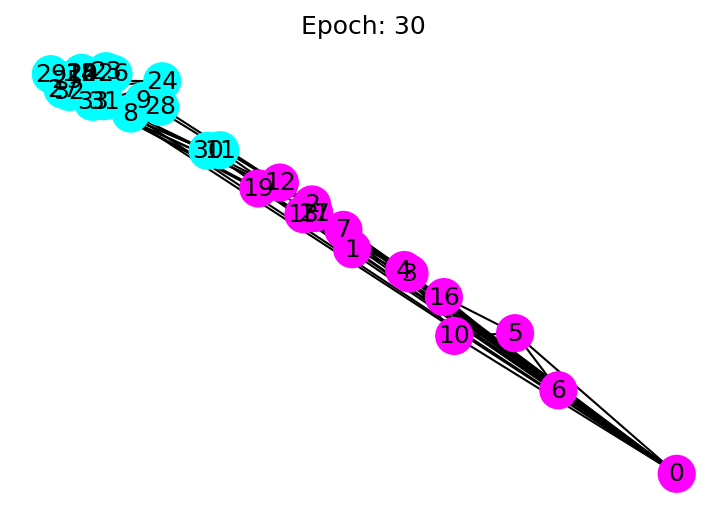

In [70]:
fig = plt.figure(dpi=150)
fig.clf()
ax = fig.subplots()
draw(30)  # dra

In [63]:
ani = animation.FuncAnimation(fig, draw, frames=len(all_logits), interval=200)

In [64]:
type(ani)

matplotlib.animation.FuncAnimation

In [65]:
from IPython.display import HTML
HTML(ani.to_html5_video())

RuntimeError: Requested MovieWriter (ffmpeg) not available

In [66]:
%matplotlib notebook
ani = animation.FuncAnimation(fig, draw, frames=len(all_logits), interval=200)
plt.show()

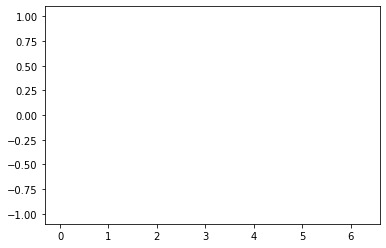

In [67]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.animation
import numpy as np

t = np.linspace(0,2*np.pi)
x = np.sin(t)

fig, ax = plt.subplots()
l, = ax.plot([0,2*np.pi],[-1,1])

animate = lambda i: l.set_data(t[:i], x[:i])

ani = matplotlib.animation.FuncAnimation(fig, animate, frames=len(t))
plt.show()

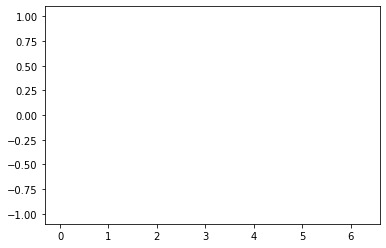

In [68]:
import matplotlib.pyplot as plt
import matplotlib.animation
import numpy as np

t = np.linspace(0,2*np.pi)
x = np.sin(t)
fig, ax = plt.subplots()
l, = ax.plot([0,2*np.pi],[-1,1])
animate = lambda i: l.set_data(t[:i], x[:i])
ani = matplotlib.animation.FuncAnimation(fig, animate, frames=len(t))
plt.show()